In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
import seaborn as sns
import scipy.signal as sps
from scipy.stats import zscore
from sklearn.cluster import KMeans

def data_plotter(variable_to_plot):
    # This function will take any slice of your dataframes (e.g. signals_train.Amb_WindSpeed_Avg['T01'])
    # and plot its value against time.
    # This requires you to have the timestamp as an index.
    # Also allows to plot the first n points of the series (e.g. data_plotter(signals_train.Amb_WindSpeed_Avg['T01'][0:1000]) )
    
    plt.rc('font', size=10) 
    fig1,axs1 = plt.subplots(1,1,figsize = (6,6))
    axs1.plot(variable_to_plot.index,variable_to_plot.values)
    plt.tight_layout()             
    plt.show()
    return

def power_cepstrum(signal,cepstrum_length,fs,cutoff):
    _, Pyy = sps.welch(signal,fs,nperseg=cepstrum_length,nfft=2**10,return_onesided=True)
#    _, Pyy = sps.welch(signal,fs,nfft=2**12,return_onesided=True)

    powerceps = np.abs(np.fft.irfft(np.log(Pyy,out=np.zeros_like(Pyy), where=(Pyy!=0)))) 
    return powerceps[:cutoff]

def rolling_window(a, window, step_size):
    shape = (np.int((a.shape[-1]-window)/step_size),window)
    rolled = np.empty(shape)
    
    for i in np.arange(shape[0]):
        rolled[i,:] = a[i*step_size: i*step_size + window]
    
    return rolled

In [ ]:
# Load the training data
failures_train = pd.read_csv('wind-farm-1-failures-training.csv',sep=';')
logs_train = pd.read_csv('wind-farm-1-logs-training.csv',sep=';')
metmast_train = pd.read_csv('wind-farm-1-metmast-training.csv',sep=';')
signals_train = pd.read_csv('wind-farm-1-signals-training.csv',sep=';')

In [3]:
# Add turbines and timestamps as indices. 
# Translate time stamps to datetime objects

failures_train.Timestamp = pd.to_datetime(failures_train.Timestamp)
failures_train.Timestamp = failures_train.Timestamp.apply(lambda d: d.replace(tzinfo=None))
failures_train.set_index(['Turbine_ID','Timestamp'],inplace = True) # this line adds them as index and removes them as regular column
#failures_train.set_index(['Turbine_ID','Timestamp']) # this line adds them as index and keeps the regular columns

logs_train.TimeDetected = pd.to_datetime(logs_train.TimeDetected)
logs_train.TimeDetected = logs_train.TimeDetected.apply(lambda d: d.replace(tzinfo=None))
logs_train = logs_train.rename(columns = {'UnitTitle':'Turbine_ID'})  #Here, we rename some columns for consistency.
logs_train.set_index(['Turbine_ID','TimeDetected'],inplace = True)

metmast_train.Timestamp = pd.to_datetime(metmast_train.Timestamp)
metmast_train.Timestamp = metmast_train.Timestamp.apply(lambda d: d.replace(tzinfo=None))
metmast_train.set_index(['Timestamp'],inplace = True)

signals_train.Timestamp = pd.to_datetime(signals_train.Timestamp)
signals_train.Timestamp = signals_train.Timestamp.apply(lambda d: d.replace(tzinfo=None))
signals_train.set_index(['Turbine_ID','Timestamp'],inplace = True)
#signals_train.set_index(['Turbine_ID','Timestamp'],inplace = True)

In [4]:
# The scada measures the temperature of each phase of the generator
# Here we create one combined temperature metric: T_tot = sqrt(Ta^2 + Tb^2 + Tc^2)

signals_train['Gen_tot_temp'] = np.sqrt((signals_train['Gen_Phase1_Temp_Avg']**2 + signals_train['Gen_Phase2_Temp_Avg']**2 + signals_train['Gen_Phase3_Temp_Avg']**2)/3)
#signals_train['Gen_tot_temp'] = (signals_train['Gen_Phase1_Temp_Avg'] + signals_train['Gen_Phase2_Temp_Avg'] + signals_train['Gen_Phase3_Temp_Avg'])/3


# Sort Data
signals_train.sort_index(inplace = True)
metmast_train.sort_index(inplace = True)

failures_train.sort_index(level=0, ascending=True, inplace=True) # sort based on turbine
failures_train['Error'] = 1    # Add a column with a numeric value for an error




In [5]:
fs = 1/(10*60)
cepstrum_length = 2**7
cutoff = 2**6
window_length = 24*6*5
step_size = 1
clustered_turb = 'T06'

In [6]:
output_windows = rolling_window(signals_train.loc[clustered_turb].Gen_tot_temp,window_length,step_size)
input_windows = rolling_window(signals_train.loc[clustered_turb].Amb_WindSpeed_Avg,window_length,step_size)

In [7]:
cepstra_windows = np.asarray([power_cepstrum(output_windows[i],cepstrum_length,fs,cutoff) - power_cepstrum(input_windows[i],cepstrum_length,fs,cutoff) for i in np.arange(output_windows.shape[0])])

In [8]:
weights = np.sqrt(np.arange(cutoff))
windowed_weighted_cepstra = np.nan_to_num(np.asarray([weights * cepstra_windows[i] for i in np.arange(cepstra_windows.shape[0])]))

C:\Users\Olauwers\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


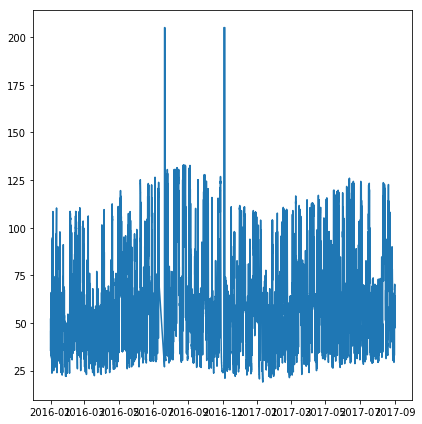

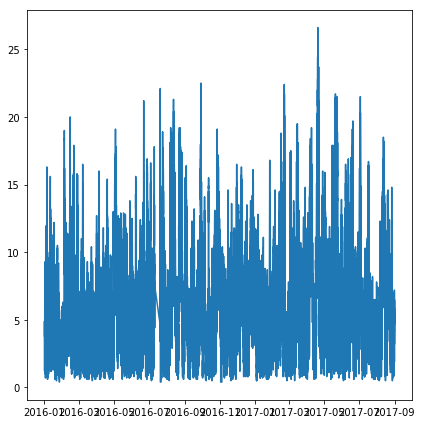

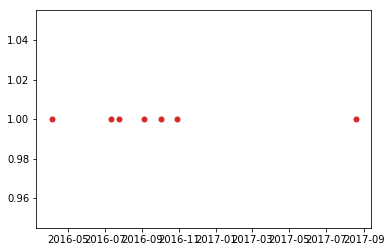

In [9]:
amount_of_clusters = 2
kmeans = KMeans(n_clusters = amount_of_clusters,n_init=100).fit(windowed_weighted_cepstra)
kmeans_euclid = KMeans(n_clusters = amount_of_clusters,n_init=100).fit(output_windows)


data_plotter(signals_train.loc[clustered_turb].Gen_tot_temp)
data_plotter(signals_train.loc[clustered_turb].Amb_WindSpeed_Avg)
plt.plot(failures_train.loc[clustered_turb].index, failures_train.Error[clustered_turb],'.',markersize = 10, color = 'C3')

                                                                          Remarks  \
Turbine_ID Timestamp                                                                
T01        2016-07-18 02:10:00                               Gearbox pump damaged   
           2017-08-11 13:14:00                            Transformer fan damaged   
T06        2016-04-04 18:53:00                          Error in pitch regulation   
           2016-07-11 19:48:00                                 Generator replaced   
           2016-07-24 17:01:00               Generator temperature sensor failure   
           2016-09-04 08:08:00                   High temperature generator error   
           2016-10-02 17:08:00  Refrigeration system and temperature sensors i...   
           2016-10-27 16:26:00                                 Generator replaced   
           2017-08-19 09:47:00                                 Oil leakage in Hub   
T07        2016-04-30 12:40:00  High temperature in generator bea

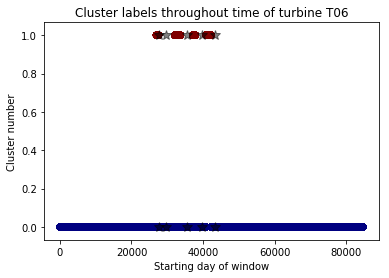

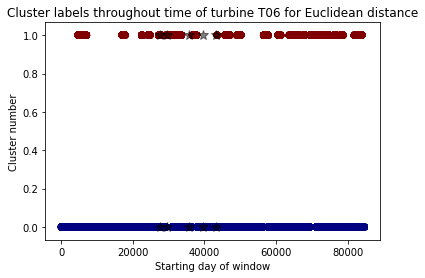

In [10]:
print(failures_train[['Remarks','Component']])

fault_indices = np.asarray([int((failures_train.loc[clustered_turb].index.to_period('D')[i] - signals_train.loc[clustered_turb].index.to_period("D").unique()[0]).freqstr[:-1]) for i in range(failures_train.loc[clustered_turb].index.to_period('D').size)])
fault_indices = 24*6*fault_indices

colors = cm.get_cmap('jet',amount_of_clusters)

plt.figure()
plt.title('Cluster labels throughout time of turbine ' + clustered_turb)
plt.xlabel('Starting day of window')
plt.ylabel('Cluster number')
for i in np.arange(amount_of_clusters):  # Note that we only plot the middel five errors here, as for turbine T06, these are the faults related to the generator.
    plt.plot(fault_indices[1:-1], failures_train.Error[clustered_turb][1:-1]-1+i,'*',markersize = 10, color = 'black',alpha=0.5)
plt.scatter(np.arange(kmeans.labels_.size),kmeans.labels_,color=colors(kmeans.labels_))
plt.show()

plt.figure()
plt.title('Cluster labels throughout time of turbine ' + clustered_turb + ' for Euclidean distance')
plt.xlabel('Starting day of window')
plt.ylabel('Cluster number')
for i in np.arange(amount_of_clusters):
    plt.plot(fault_indices[1:-1], failures_train.Error[clustered_turb][1:-1]-1+i,'*',markersize = 10, color = 'black',alpha=0.5)
plt.scatter(np.arange(kmeans_euclid.labels_.size),kmeans_euclid.labels_,color=colors(kmeans_euclid.labels_))
plt.show()

In [ ]:
#import pickle

#pickle.dump(kmeans_stochastic, open("kmeansstochastic.pkl", "wb"))
#kmeans = pickle.load(open("kmeanscepstral.pkl", "rb"))


In [ ]:
#np.savetxt('faultdays.csv',fault_indices,delimiter = ',')

In [ ]:
fault_indices

In [ ]:
fault_indices = np.asarray([int((failures_train.loc[clustered_turb].index.to_period('T')[i] - signals_train.loc[clustered_turb].index.to_period("T").unique()[0]).freqstr[:-1]) for i in range(failures_train.loc[clustered_turb].index.to_period('T').size)])
fault_indices//10

In [ ]:
#np.savetxt('faulttenminutes.csv',fault_indices//10,delimiter = ',')

In [ ]:
#np.vstack((np.arange(kmeans.cluster_centers_[0].shape[0]),kmeans.cluster_centers_[0])).shape
#np.savetxt('clustercenterscepstral1.csv',np.vstack((np.arange(kmeans.cluster_centers_[0].shape[0]),kmeans.cluster_centers_[1])).T, delimiter=",")